# Parameter optimization

### Get the data already preprocessed

- `poly_data` and `poly_names` from [polynomial_features](polynomial_features.ipynb)
- `vector_data` and `vector_names` from [save_email_features](save_email_features.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

HOME_PATH = os.path.expanduser('~')
DATA_PATH = os.path.join(HOME_PATH, 'Desktop', 'raw_data', 'ml')

poly_path = os.path.join(DATA_PATH, 'poly_data.pkl')
poly_names_path = os.path.join(DATA_PATH, 'poly_names.pkl')
with open(poly_path, 'rb') as f:
    poly_data = pickle.load(f)
with open(poly_names_path, 'rb') as f:
    poly_names = pickle.load(f)
    
vector_path = os.path.join(DATA_PATH, 'vector_data.pkl')
vector_names_path = os.path.join(DATA_PATH, 'vector_names.pkl')

with open(vector_path, 'rb') as f:
    vector_data = pickle.load(f)
with open(vector_names_path, 'rb') as f:
    vector_names = pickle.load(f)

Merge dictionaries and feature lists

In [2]:
from copy import deepcopy
final_data = deepcopy(poly_data)
for key, item in final_data.items():
    item.update(vector_data[key])
    
print 'inner keys:', len(final_data['METTS MARK'].keys()),\
      'compare:', len(vector_data['METTS MARK'].keys()) +\
      len(poly_data['METTS MARK'].keys()) - 1

inner keys: 4290 compare: 4290


In [3]:
from copy import deepcopy
final_data = deepcopy(poly_data)
for key, item in final_data.items():
    item.update(vector_data[key])
    
print 'inner keys:', len(final_data['METTS MARK'].keys()),\
      'compare:', len(vector_data['METTS MARK'].keys()) +\
                  len(poly_data['METTS MARK'].keys()) - 1

vector_names.remove('poi')
final_names = poly_names + vector_names
print 'Features:', len(final_names), 'compare:', len(final_data['METTS MARK'].keys())

inner keys: 4290 compare: 4290
Features: 4290 compare: 4290


Convert data to a usable array

In [23]:
from tools.feature_format import featureFormat

array = featureFormat(final_data, final_names,
                      keep_keys=True, remove_NaN=True, remove_all_zeroes=False)
keys, labels, features =\
        array[:,0], array[:,1].astype(np.float16), array[:, 2:].astype(np.float32)

print 'Keys, labels, features shapes:', keys.shape, labels.shape, features.shape

Keys, labels, features shapes: (148,) (148,) (148, 4289)


In [5]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels =\
train_test_split(features, labels, test_size=0.4, random_state=42)

### Test on different classifiers

In [7]:
#Scoring function
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
import scipy.stats as st

def t_delta(percent, scores):
    """
    Returns the size of a t-test error bar that defines a given percent confidence 
    """
    mean, sem = np.mean(scores), st.sem(scores)
    interval = st.t.interval(percent/float(100), len(scores)-1, loc=mean, scale=sem)
    delta = mean - interval[0]
    return delta


def scores(clf, features, labels, printout=False):
    title = str(type(clf))
    title = title.split('.')[-1][:-2]
    
    if printout:
        print '%s:\n' % title
    
    summary_dict = {title: {}}
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=41)
    
    for scoring in ['recall', 'precision', 'f1']:
        scores = cross_val_score(clf, features, labels, cv=cv, scoring=scoring)
        mean =  np.mean(scores)
        # t-test 95% confidence interval
        delta = t_delta(95, scores)
        
        summary_dict[title][scoring] = (mean, delta)
        
        if printout:
            print '-', scoring, scores
            print 'Mean: %0.2f (+/-%0.2f)' % (mean, delta)
    
    return summary_dict

In [9]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
nb_scores = scores(clf, features, labels, printout=True)

GaussianNB:

- recall [ 0.25        0.14285714  0.28571429]
Mean: 0.23 (+/-0.18)
- precision [ 0.4  1.   1. ]
Mean: 0.80 (+/-0.86)
- f1 [ 0.30769231  0.25        0.44444444]
Mean: 0.33 (+/-0.25)


In [11]:
### Try a variety of classifiers
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

clfs = [SVC(), 
        AdaBoostClassifier(),
        ExtraTreesClassifier(),
        RandomForestClassifier(),
        LogisticRegression()]

scores_list = []
for clf in clfs:
    title = str(type(clf))
    title = title.split('.')[-1][:-2]
    scores_list.append(scores(clf, train_features, train_labels))

/Users/TRN/anaconda/envs/ml27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/TRN/anaconda/envs/ml27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/TRN/anaconda/envs/ml27/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/Users/TRN/anaconda/envs/ml27/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


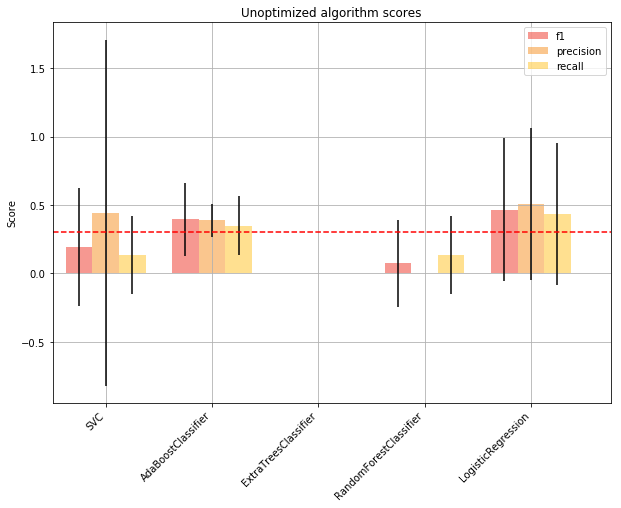

In [22]:
clfs = []
f1s = []
precisions = []
recalls = []

for dicto in scores_list:
    key, item = dicto.items()[0]
    clfs.append(key)
    f1s.append(item['f1'])
    precisions.append(item['precision'])
    recalls.append(item['recall'])

score_list = ['f1', 'precision', 'recall']
values = [f1s, precisions, recalls]
colors = ['#EE3224', '#F78F1E', '#FFC222']

pos = list(range(len(clfs)))
width = 0.25

plt.close('all')
fig, ax = plt.subplots(figsize=(10,7))
for i, value in enumerate(values):
    means, stds = zip(*value)
    plt.bar([p + width*i for p in pos],
            means,
            width,
            yerr=stds,
            alpha=0.5,
            color=colors[i],
            label=score_list[i])

ax.set_ylabel('Score')
ax.set_title('Unoptimized algorithm scores')
ax.set_xticks([p + width for p in pos])
ax.set_xticklabels(clfs, rotation=45, horizontalalignment='right')
plt.xlim(min(pos)-width, max(pos)+width*4)

ax.hlines(0.3, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dashed', colors='r')

plt.legend(loc='upper right')
plt.grid()
plt.show()

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline 

pipe = Pipeline(steps=[('estimator', None)])

SV = SVC(random_state=42)
SV_params = {'estimator': [SV],
             'estimator__C': [1e-2, 1e-1, 1, 1e1, 1e2],
             'estimator__kernel': ['linear', 'rbf'],
             'estimator__tol': [1e-4, 5e-4, 1e-3],
             'estimator__class_weight': [None, 'balanced']}

DTC = DecisionTreeClassifier(random_state=42)
ABC = AdaBoostClassifier(base_estimator=DTC, random_state=42)
ABC_params = {'estimator': [ABC],
              'estimator__base_estimator__max_depth': [None, 3, 6, 12, 24, 48],
              'estimator__base_estimator__min_samples_leaf': [1, 2, 4, 8, 16],
              'estimator__base_estimator__class_weight': [None, 'balanced'],
              'estimator__n_estimators': [25, 50, 100, 250],
              'estimator__learning_rate': [0.01, 0.1, 1, 10]}

LR = LogisticRegression(solver='lbfgs')
LR_params = {'estimator': [LR],
             'estimator__C': [1e-2, 1e-1, 1, 1e1, 1e2],
             'estimator__class_weight': [None, 'balanced'],
             'estimator__max_iter': [100, 200],
             'estimator__tol': [1e-4, 5e-4, 1e-3],
             'estimator__warm_start': [False, True]}

all_params = [SV_params, ABC_params, LR_params]

In [82]:
from sklearn.model_selection import GridSearchCV
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    all_grid = GridSearchCV(pipe,
                           param_grid=all_params,
                           cv=4,
                           verbose=1,
                           n_jobs=-1,
                           scoring='f1')
    
    all_grid.fit(train_features, train_labels)

Fitting 4 folds for each of 1140 candidates, totalling 4560 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 738 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1189 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1994 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 2753 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 3762 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 4560 out of 4560 | elapsed: 17.5min finished


In [184]:
grid_path = os.path.join(DATA_PATH, 'all_grid.pkl')

with open(grid_path, 'wb') as f:
    pickle.dump(all_grid, f, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
def find_top_scores(grid, class_types, cutoff=5, cv=4, verbose=False):
    """
    List the top scores from a fitted gridCV search
    
    returns list of tuples with (rank, estimator_label, test_scores, real index)
    """

    grid_results = grid.cv_results_

    score_keys = []
    end_str = '_test_score'
    start_str = 'split'
    for num in range(cv):
        complete_str = start_str+str(num)+end_str
        score_keys.append(complete_str)

    ranks = grid_results['rank_test_score']
    names_scores = []
    
    for rank in range(1,cutoff+1):
        
        idx_list = np.where(ranks == rank)[0]
        # More than one estimator can have the same rank
        for i in idx_list:
            try:
                estimator = grid_results['params'][i]['estimator']
            except KeyError:
                estimator = class_types[0][0]()
            
            for tup in class_types:
                if isinstance(estimator, tup[0]):
                    estimator_label = tup[1]
           
            test_scores = []
            for key in score_keys:
                test_scores.append(grid_results[key][i])
            
            if verbose:
                print(estimator_label)
                print np.mean(test_scores), np.std(test_scores)
            
            names_scores.append((rank, estimator_label, test_scores, i))
    
    return names_scores

In [31]:
class_types = [(SVC, 'SVC'), (AdaBoostClassifier, 'AdaBoost'), [LogisticRegression, 'LR']]
top_scores = find_top_scores(all_grid, class_types, cutoff=250)

In [33]:
import matplotlib.patches as mpatches

def plot_scores(score_list):
    """
    plots scores from score_list generated by find_top_scores
    
    score_list should be a list of tuples in the form:
    tup[0] = rank
    tup[1] = estimator label string
    tup[2] = list of scores
    tup[3] = real_index
    """
    
    ranks = [tup[0] for tup in score_list]
    labels = [tup[1] for tup in score_list]
    scores = [tup[2] for tup in score_list]
    means = [np.mean(x) for x in scores]
    deltas = [t_delta(95, x) for x in scores]
    
    plt.close('all')
    ind = len(score_list)
    fig = plt.figure(1, figsize=(10, 7), tight_layout=True)
    ax = fig.gca(title='Estimator scores',
                 xlabel='Rank',
                 xlim=[-1, ind],
                 xticks=range(ind),
                 ylabel='average score')
    bar_list = ax.bar(range(ind), means, yerr=deltas, align='center')
    ax.set_xticklabels(ranks)
    ax.hlines(0.3, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dashed', colors='r')
    # color bar based on label selected features red
    color_dict = {'AdaBoost': 'b',
                  'SVC': 'g',
                  'LR': 'm'}
    for i, name in enumerate(labels):
        bar_list[i].set_color(color_dict[name])
        
    # create custom legend
    blue_patch = mpatches.Patch(color='blue', label='Adaboost')
    green_patch = mpatches.Patch(color='green', label='SVC')
    magenta_patch = mpatches.Patch(color='magenta', label='LR')
    plt.legend(handles=[blue_patch, green_patch, magenta_patch])
    plt.show()

/Users/TRN/anaconda/envs/ml27/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


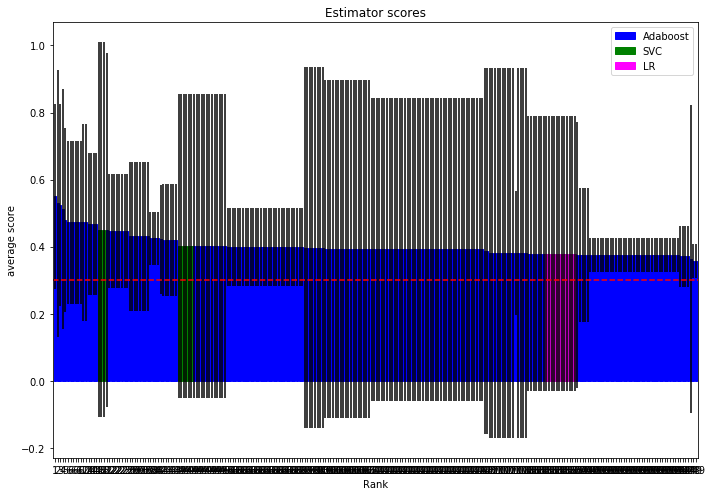

In [34]:
plot_scores(top_scores)

In [37]:
from scipy.stats import variation

def t_score(score, cutoff=0.3):
    mean, sem = np.mean(score), st.sem(score)
    val = st.t.cdf(0.3, len(score)-1, loc=mean, scale=sem)
    return val

def rank_by_t_score(score_list):
    """
    sorts score list by t-score
    
    score_list should be a list of tuples in the form:
    tup[0] = rank
    tup[1] = estimator label string
    tup[2] = list of scores
    tup[3] = real_index
    """
    ranks = [tup[0] for tup in score_list]
    labels = [tup[1] for tup in score_list]
    scores = [tup[2] for tup in score_list]
    real_is = [tup[3] for tup in score_list]
    ts = [t_score(score) for score in scores]
    
    all_list = zip(ranks, labels, scores, real_is, ts)
    
    all_list = sorted(all_list, key=lambda tup: tup[4])
    all_list = [tup[:4] for tup in all_list]
    
    return all_list

In [38]:
top_scores_t = rank_by_t_score(top_scores)

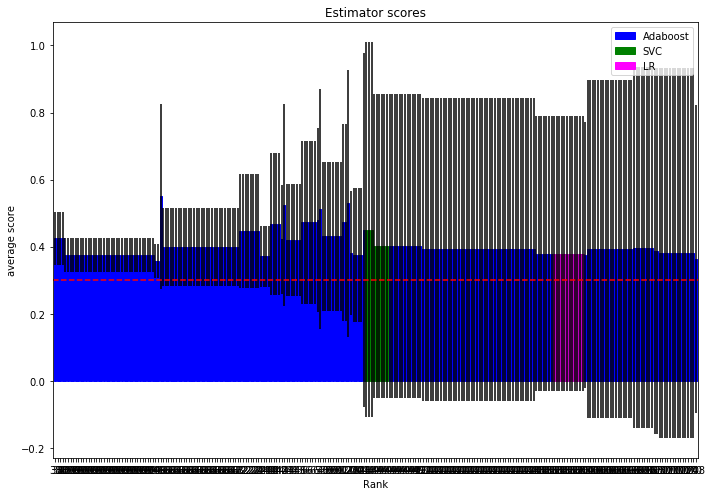

In [39]:
plot_scores(top_scores_t)

In [62]:
result_params = all_grid.cv_results_['params']
top_t_cv_idxs = [tup[3] for tup in top_scores_t[:10]]

def list_params(params, idxs):
    constants = []
    variables = []
    keys = params[idxs[0]].keys()
    keys.remove('estimator')
    
    for key in keys:
        temp_list = []
        for i in idxs:
            temp_list.append(params[i][key])
            set_list = set(temp_list)
        if len(set_list) == 1:
            constants.append((key, set_list))
        else:
            variables.append((key, temp_list))

    print 'CONSTANTS:'
    for cons in constants:
        print cons[0], cons[1]
    
    print 'VARIABLES:'
    for var in variables:
        print var[0], var[1]

In [63]:
list_params(result_params, top_t_cv_idxs)

CONSTANTS:
estimator__base_estimator__class_weight set(['balanced'])
VARIABLES:
estimator__learning_rate [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 1, 1]
estimator__base_estimator__max_depth [3, 3, 3, 3, None, None, None, None, None, None]
estimator__base_estimator__min_samples_leaf [1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
estimator__n_estimators [25, 50, 100, 250, 25, 50, 100, 250, 25, 50]


Looks like AdaBoostClassifier performs best when:
- base estimator `class_weight` is 'balanced'
- base estimator `max_depth` is 3 or None
- base estimator `min_samples_leaf` is 1 or 2
- `learning_rate` is 0.01 or 1

- `n_estimators` can be any of the values tested, so will stick to the lowest: 25

In [97]:
best = result_params[top_t_cv_idxs[0]]['estimator']
best.fit(train_features, train_labels)
pred = best.predict(test_features)
print classification_report(pred, test_labels)

             precision    recall  f1-score   support

        0.0       1.00      0.91      0.95        57
        1.0       0.38      1.00      0.55         3

avg / total       0.97      0.92      0.93        60



### Dump classifier, dataset, and features_list so that results can be tested using the course tester function in the [summary](summary.ipynb) notebook

In [109]:
import tools.tester

dump_classifier_and_data(best, final_data, final_names)